# Alternative representation of teeth

Using the fact that teeth are topologically similar to planes, we can make a 2D representation of the tooth. To do this we suggest modelling a prototype tooth, similar to a tooth prior. Calculating the difference of a tooth and the prototype, allows for modelling teeth only using said difference. The difference will be modelled as a displacement map https://en.wikipedia.org/wiki/Displacement_mapping . Instead of just modelling the displacement as a magnitude displacement along the normal, it can be modelled as a displacement in each dimension seperately for increased flexibility.

The core idea: map between each tooth and the prototype. This can be done by e.g. minimizing the energy of the teeth mesh projected to the prototype.
From here it is trivial to retrieve the displacement map between shapes.

Secondly, map between the prototype and the plane. If we constrain the prototype to be similar to spheres, many such methods exists for mapping the globe.

From this the displacement map can be modelled as a 3 channel image, which is possible to sample from by e.g. diffusion models.

To retrieve the original/generated shape, use the mapping between image and prototype to calculate the original datapoint.

As the mapping between prototype and image is predetermined, each image becomes a valid 3D shape (with intersections when noisy)

Pros:

Each pixel is it's own datapoint. Using 128x128x3 images corrosponds to 16384 points on the surface.

During the forward pass using convolutions allows points to get local information, meaning that complex structures such as textures, which are hard to capture without global shape latents in point cloud models, can be inferred.

Multiple implementations of diffusion models are freely available. They also have class conditioning implemented. In the case of poor mapping strategies, using latent diffusion allows for efficient use of diffusion space https://arxiv.org/abs/2112.10752


As a sanity check, I have tried creating a small toy dataset consisting of elipsis in polar coordinates, where I have added a bias to the radius consisting of a fourier series. With this I calculate a prototype and some mapping between datapoints and the prototype

In [1]:
from pathlib import Path

import tqdm
import numpy as np
import matplotlib.pyplot as plt

from utils import calculate_sdf, plot_sdf, get_prototype_shape, fit_shape, project_shape


In [2]:
data_dir = './data/train'
num_freq = 12
w_range = (-.5, .5)
base_r = 7
ellipsis_ratio = 2.
sdf_resolution = 500

max_radius = max(ellipsis_ratio, 1 / ellipsis_ratio) * (max(map(abs, w_range)) * num_freq + base_r)
data_dir = Path(data_dir)


In [3]:
sdf_paths = sorted((data_dir / 'sdf').iterdir(), key=lambda x: int(x.stem))
shape_paths = sorted((data_dir / 'shape').iterdir(), key=lambda x: int(x.stem))

sdfs = list()
shapes = list()
for sdf_path, shape_path in zip(tqdm.tqdm(sdf_paths), shape_paths):
    sdf = np.load(sdf_path)
    sdfs.append(sdf)
    shape = np.load(shape_path)
    shapes.append(shape)
sdfs = np.stack(sdfs)


100%|██████████| 1000/1000 [00:03<00:00, 323.33it/s]


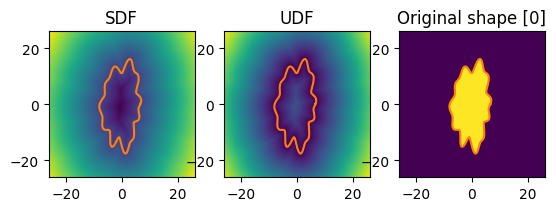

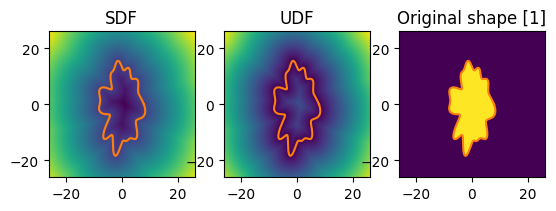

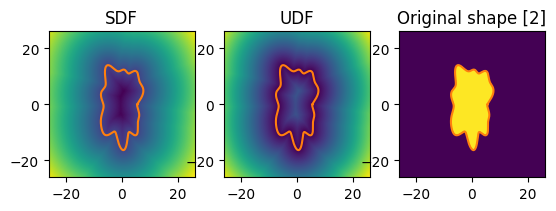

In [4]:
plot_sdf(*calculate_sdf(shapes[0], sdf_resolution, max_radius=max_radius), shapes[0], max_radius=max_radius)
plt.title('Original shape [0]')
plt.show()

plot_sdf(*calculate_sdf(shapes[1], sdf_resolution, max_radius=max_radius), shapes[1], max_radius=max_radius)
plt.title('Original shape [1]')
plt.show()

plot_sdf(*calculate_sdf(shapes[2], sdf_resolution, max_radius=max_radius), shapes[2], max_radius=max_radius)
plt.title('Original shape [2]')
plt.show()


By taking the average of all the SDFs in out dataset, we can calculate a prototype SDF. To extract a prototype shape, we run maching cubes.

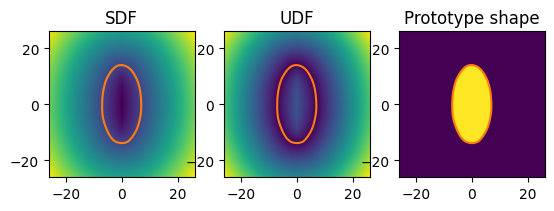

In [5]:
p_shape = get_prototype_shape(sdfs, sdf_resolution=sdf_resolution, max_radius=max_radius)
plot_sdf(*calculate_sdf(p_shape, sdf_resolution, max_radius=max_radius), p_shape, max_radius=max_radius)
plt.title('Prototype shape')
plt.show()

We want to now create the displacement map, between the prototype shape, and any other shape in the dataset. This is done by creating a projected shape, by projecting the points from the other shape to the prototype shape. By minimizing the energy in the projected shape, we ensure that each part of the other shape, is represented equally in the displacement map.


 30%|██▉       | 2999/10000 [00:03<00:08, 821.11it/s] 


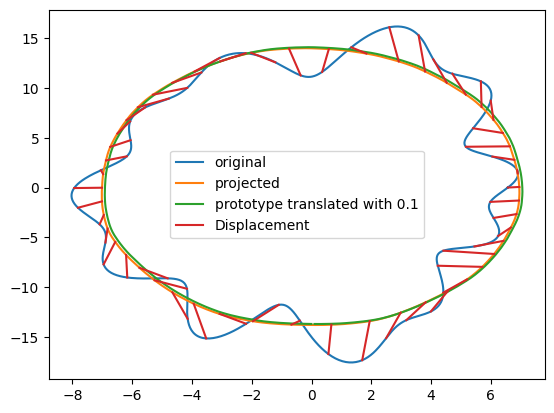

In [6]:
orig_shape = shapes[0]
shape_proj = fit_shape(
    p_shape,
    orig_shape)

plt.plot(*orig_shape, label='original')
plt.plot(*shape_proj, label='projected')
plt.plot(*(p_shape + 0.1), label='prototype translated with 0.1')
for i, (v1, v2) in enumerate(zip(orig_shape[:, ::20].T, shape_proj[:, ::20].T)):
    plt.plot((v1[0], v2[0]), (v1[1], v2[1]), c='C3', label='Displacement' if i == 0 else None)
plt.legend()
plt.show()

We now calculate the displacement map by first finding the displacement between the energy minimized projection and original shape. Then the displacment map is retrieved by interpolation.

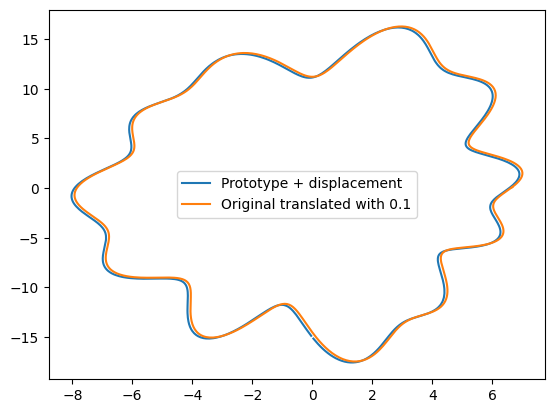

In [7]:
shape_diff = orig_shape - shape_proj
displacement_map = project_shape(p_shape, reference_shape=shape_proj, extrat_vals=shape_diff)

plt.plot(*(displacement_map + p_shape), label='Prototype + displacement')
plt.plot(*(orig_shape+0.1), label='Original translated with 0.1')
plt.legend()
plt.show()

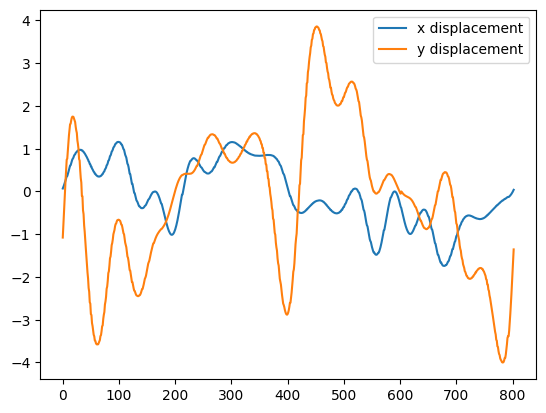

In [8]:
plt.plot(displacement_map[0], label='x displacement')
plt.plot(displacement_map[1], label='y displacement')
plt.legend()
plt.show()

Two more examples

 30%|██▉       | 2999/10000 [00:03<00:07, 935.75it/s] 


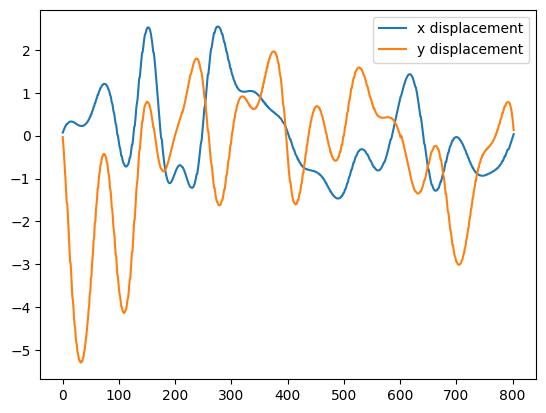

 30%|██▉       | 2999/10000 [00:03<00:07, 948.43it/s] 


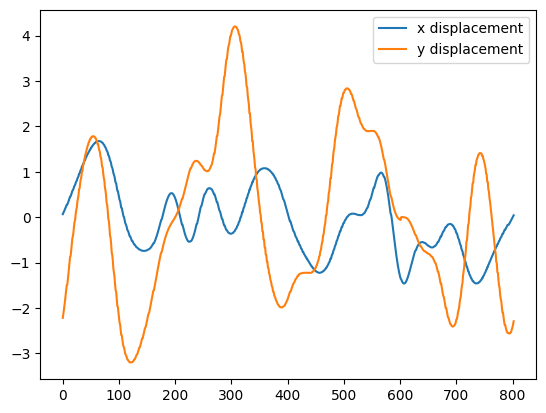

In [9]:
for orig_shape in shapes[1:3]:

    shape_proj = fit_shape(
        p_shape,
        orig_shape)
    
    shape_diff = orig_shape - shape_proj
    displacement_map = project_shape(p_shape, reference_shape=shape_proj, extrat_vals=shape_diff)

    plt.plot(displacement_map[0], label='x displacement')
    plt.plot(displacement_map[1], label='y displacement')
    plt.legend()
    plt.show()

Differences in 3D:

All the shapes in 2D are star convex, this might not be the case in 3D, but it should be _close_.

The mapping between prototype and other shape might be harder in 3D, as the parameterization is not independent for dimensions $u$ and $v$. Worst case scenario, some elastic cloth simulation should be able to do the trick.

The teeth are not closed, but can probably be closed reasonably well using something like the winding number as done in fig 2 in https://onlinelibrary.wiley.com/doi/full/10.1111/cgf.14916.
